<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Multinomial-regression" data-toc-modified-id="Multinomial-regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multinomial regression</a></span><ul class="toc-item"><li><span><a href="#there-are-3-types-of-data:-test-data,-train-data,-validation-data" data-toc-modified-id="there-are-3-types-of-data:-test-data,-train-data,-validation-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>there are 3 types of data: test data, train data, validation data</a></span></li><li><span><a href="#evaluate-model-with-test-data" data-toc-modified-id="evaluate-model-with-test-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>evaluate model with test data</a></span></li><li><span><a href="#evaluate-model-with-the-whole-data-set" data-toc-modified-id="evaluate-model-with-the-whole-data-set-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>evaluate model with the whole data set</a></span></li></ul></li></ul></div>

In [1]:
"""
Multinomial logistic regression for "Decoding" process
xaq and zhengwei
"""
from pandas import DataFrame, read_csv
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
#from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import matplotlib.pyplot as plt
#from twoCol_NN_data import *
from boxtask_func import *

TEST_SIZE = 0.1  # ratio of test data set 
N_SPLITS = 2 # "K" in K-fold cross validation 

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# pdf.fontype and ps.fontype must be set to 42 in order for text in exported figure to be editable in Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "CMU Serif"

In [3]:
#colors = ['g', 'c', 'b', 'r', 'm']
na = 5


#if you use neural data
bb_df = read_csv('./data/bb_df.csv') #behavior belief =[belief for box1, beleif for box2]
bb_df_prev = read_csv('./data/recoding_bb_prev_df.csv') #behavior belief =[belief for box1, beleif for box2]
bb_df_now = read_csv('./data/recoding_bb_now_df.csv') #behavior belief =[belief for box1, beleif for box2]


In [4]:
nq = 10

In [5]:
data = read_csv('./data/neural_decoding_data.csv')
data_POMDP =read_csv('./data/bb_df.csv')

nb_df_raw = data[['neural_belief1', 'neural_belief2','location']].to_numpy()#[:10000]
a_df = data['action'].to_numpy()#[:10000]
l_df = data['location'].to_numpy()#[:10000]
reward_df_raw = data['reward']

pih_raw = data[['p1', 'p2','p3','p4','p5']].to_numpy()

pih_raw_POMDP = data[['POMDP_p1', 'POMDP_p2','POMDP_p3','POMDP_p4','POMDP_p5']].to_numpy()
bel_raw_POMDP = (data[['POMDP_belief1', 'POMDP_belief2']].to_numpy() + 1/2)/nq

X = nb_df_raw
a = np.expand_dims(a_df, axis = 1).astype(int)
l = np.expand_dims(l_df, axis = 1).astype(int)
pih = pih_raw


# X = np.concatenate((bel_raw_POMDP, nb_df_raw[:, 2:]), axis = 1)
# a = np.expand_dims(a_df, axis = 1).astype(int)
# pih = pih_raw_POMDP


In [6]:
# TX = read_csv('neural_decoding_X.csv')
# X = TX.to_numpy() #belief1, belief2, location

# Ta =  read_csv('neural_decoding_y.csv') 
# a = Ta.to_numpy()
# a = a.astype(int)

# Tpih = read_csv('neural_decoding_POMDPpolicy.csv')
# pih = Tpih.to_numpy()

# X.shape, a.shape, pih.shape

In [7]:
# idx_0 = np.where(nb_df_raw[:, -1] == 0)[0]
# plt.hist2d(nb_df_raw[idx_0, 0].squeeze(), nb_df_raw[idx_0, 1].squeeze())

In [8]:
# idx_0 = np.where(nb_df_raw[:, -1] == 0)[0]
# plt.hist2d(bel_raw_POMDP[idx_0, 0].squeeze(), bel_raw_POMDP[idx_0, 1].squeeze())

In [9]:
# idx_0 = np.where(X[:, 2] == 0)[0]
# plt.hist2d(X[idx_0, 0].squeeze(), X[idx_0, 1].squeeze())

In [10]:
T = X.shape[0]
T

20000

In [11]:
b = X[:, 0:2]
L = X[:, 2].astype(int)
nL=3

In [12]:
nonlinearity = 2  #RBF regression

if nonlinearity == 1:
    print("Using indicator nonlinearity.")
    
    #Indicator function on quantized beliefs
    dq = 0.5
    bq = np.rint( b/dq - .5 ).astype(int)
    bi = bq - np.min(np.min(bq)) 
    
    nbq = len(np.unique(bq))
    biqK = np.zeros((T, nbq, nbq, nL))
    for t in range(T):
        biqK[t, bi[t, 0], bi[t, 1], L[t]] = 1
    
    biq1 = biqK.reshape(T, -1)
    f = biq1
    
elif nonlinearity == 2:
    print("Using RBF nonlinearity.")
    
    # Radial Basis Functions
    dq = .2 # RBF spacing
    sigma2 = (.5*dq)**2 # length scale
    
    # define centers
    q1L = np.arange(dq/2, 1, dq) # centers on each axis
    nq1 = len(q1L)
    nqt = nq1**2
   
    qL = np.zeros((nqt,2))
    ind = 0
    
    for qi in q1L:
        for qj in q1L:
            qL[ind, :] = np.array([qi, qj])
            ind = ind + 1
    
    b_RBF = np.zeros((T, nqt, nL))
    for t in range(T):
        for idx in range(nqt):
            b_RBF[t, idx, L[t]] = np.exp( -( (b[t,0]-qL[idx,0])**2 + (b[t,1]-qL[idx,1])**2 )/(2*sigma2) )
            
    f = b_RBF.reshape(T, -1)
else:
    print("Using linear features.")
    f = X[:2]

Using RBF nonlinearity.


In [13]:
# indicator function for actions (for mnrfit)
na = pih.shape[1]

In [14]:
ai = np.zeros((T, na), dtype = int)
for t in range(T):
    ai[t, a[t]] = 1

## Multinomial regression

In [15]:
Tdata = 18000  # use less data
fsource = f[:Tdata,:]
#atarget = ai[:Tdata,:]
atarget = a[:Tdata, :]
#pihs = pih[:Tdata,:]

In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', solver='newton-cg')
lr.fit(fsource, np.ravel(atarget))

LogisticRegression(solver='newton-cg')

In [17]:
Ttest = 1000
ftest = f[Tdata:Tdata+Ttest,:]
pih_test = pih[Tdata:Tdata+Ttest,:]

In [18]:
pic_test = lr.predict_proba(ftest) 

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


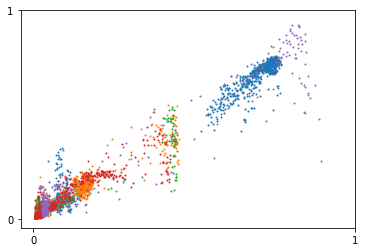

In [19]:
plt.plot(pih_test, pic_test, '.', markersize=2)
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.show()

### there are 3 types of data: test data, train data, validation data

In [20]:
y = np.hstack((a, pih, l))

In [21]:
# separate test data set
X_train, X_test, y_train, y_test = train_test_split(f, y, test_size=TEST_SIZE, random_state = 1)

In [22]:
#regr = LinearRegression() # linear regression is used for encoding process
#regr = KernelRidge(alpha=0.01, gamma=0.1, kernel='rbf') # linear regression(small gamma) with RBF kernel
regr = LogisticRegression() 


In [23]:
# now we use only train data 
# why use StratifiedKFold?: The folds are made by preserving the percentage of samples for each class.
k_fold = StratifiedKFold(n_splits=N_SPLITS) # seperate train data and validation data


In [24]:
# why argmax(1)? split cannot simply handle multidimension y. 
# ref: https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
for train_index, val_index in k_fold.split(X_train, y_train.argmax(1)):
    #print("TRAIN:", train_index, "TEST:", val_index)
    x_train_kf, x_val_kf = X_train[train_index], X_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    regr.fit(x_train_kf, y_train_kf[:, 0]) # fit the model
    pred = regr.predict(x_val_kf) # predict based on current model -> use validation data for evaluation

    print('score', r2_score(y_val_kf[:, 0], pred, multioutput='raw_values')) # get r2 score

/Users/zhengwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score [0.15353187]
score [0.14679328]


/Users/zhengwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### evaluate model with test data

In [25]:
predic_X_test = regr.predict_proba(X_test) 
predic_X_test = predic_X_test / np.tile(np.sum(predic_X_test, axis = 1), (5,1)).T

In [26]:
# fig, ax = plt.subplots(2,1, figsize= (20, 4))
# #ax[0] = fig.add_subplot(211)
# ax[0].imshow(predic_X_test.T[:, :100], interpolation='Nearest', vmin = 0, vmax = 1)
# ax[0].set_ylabel('neural decoding')

# ax[1].imshow(y_test.T[1:, :100], interpolation='Nearest', vmin = 0, vmax = 1)
# ax[1].set_ylabel('behavioral policy')

In [27]:
# # plot: compare raw data vs prediction
# #plt.scatter(a_df_test, a_dec_test, s=0.005, c='blue', marker='o')
# plt.plot(y_test[:, 1:], predic_X_test, '.', markersize = 3)
# #plt.colorbar()
# plt.xlabel('true')
# plt.ylabel('estimated')
# plt.title('decoding: test data')
# plt.xticks([0, 1])
# plt.yticks([0, 1])
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()

In [28]:
"""
color code for actions
"""
act_cmap = [[0, 0, 0],
       [0, 0.5, 1],
       [0, 0.75, .25],
       [.75, .75, 0],
       [1, 0.75, 0]
      ] 

In [29]:
markers = ['*', '>', 'o']

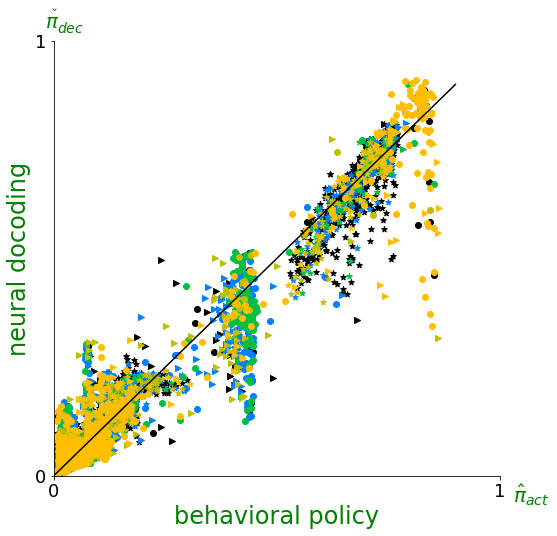

In [37]:
line_x = np.linspace(-.9,.9,num=11)
line_y = np.linspace(-.9,.9,num=11)

g = [[] for i in range(na*nL)]
h = [[] for i in range(na)]
fig_decoding, ax = plt.subplots(1,1,figsize=(8,8))
# plt.suptitle('Decoding', fontsize = 24, fontweight='bold')

for i in range(na):
    for j in range(nL):
        idx_loc = np.where(y_test[:,-1] == j)[0]
        idx_act = np.where(y_test[:, 0] == i)[0]
        idx_loc_act= list(np.intersect1d(idx_act, idx_loc))
        #print(idx_loc_act)
        g[i * nL + j] = ax.scatter(y_test[idx_loc_act, 1:-1].reshape(-1, 1), 
                          predic_X_test[idx_loc_act,:].reshape(-1, 1), color = act_cmap[i], 
                          marker = markers[j])

#ax.legend(g, ['do nothing',   'go to center',   'go to box1',   'go to box2',   'press button'], fontsize = 20)
ax.plot(line_x, line_y,c='k')
ax.set(xlim = [0, 1], ylim = [0, 1],xticks=[0, 1], yticks = [0, 1])
ax.set_xlabel('behavioral policy', fontsize = 24, color = 'green')
ax.set_ylabel('neural docoding', fontsize = 24, color = 'green')
ax.tick_params(labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.text(-0.02, 1.03, '$\pi^{\check}_{dec}$',  fontsize = 20.0, color = 'green')
ax.text(1.03, -0.06, '$\hat{\pi}_{act}$',  fontsize = 20.0, color = 'green')


for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(18)



#fig_decoding.savefig('decoding.pdf', format = 'pdf', bbox_inches="tight")


findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


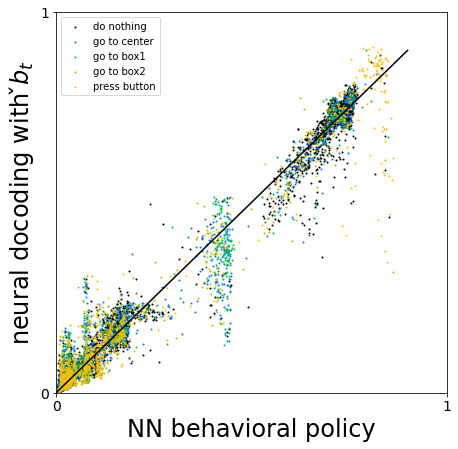

In [31]:
line_x = np.linspace(-.9,.9,num=11)
line_y = np.linspace(-.9,.9,num=11)


h = [[] for i in range(na)]
fig_decoding, ax = plt.subplots(1,1,figsize=(7,7))

for i in range(na):
    idx_act = np.where(y_test[:, 0] == i)[0]
    h[i] = ax.scatter(y_test[idx_act, 1:-1].reshape(-1, 1), predic_X_test[idx_act,:].reshape(-1, 1), 
                      color = act_cmap[i], s = 1)
    
ax.legend(h, ['do nothing',   'go to center',   'go to box1',   'go to box2',   'press button'])
ax.plot(line_x, line_y,c='k')
ax.set(xlim = [0, 1], ylim = [0, 1],xticks=[0, 1], yticks = [0, 1])
ax.set_xlabel('NN behavioral policy', fontsize = 24)
ax.set_ylabel('neural docoding with $\check{b}_t$', fontsize = 24)
ax.tick_params(labelsize=14)



### evaluate model with the whole data set

In [32]:
predic_X_all = regr.predict_proba(f) 

Text(0, 0.5, 'behavior policy IRC')

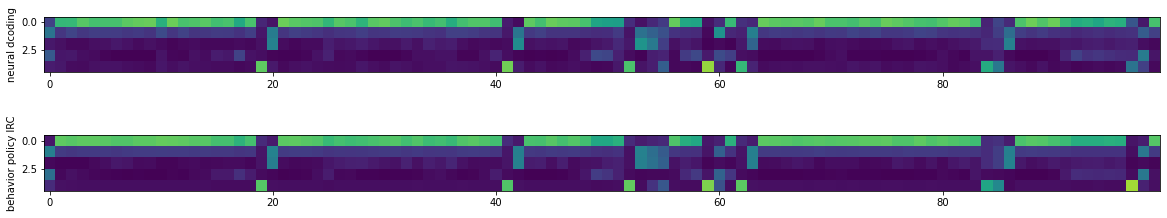

In [33]:
fig, ax = plt.subplots(2,1, figsize= (20, 4))
#ax[0] = fig.add_subplot(211)
ax[0].imshow(predic_X_all.T[:, :100], interpolation='Nearest', vmin = 0, vmax = 1)
ax[0].set_ylabel('neural dcoding')

ax[1].imshow(y.T[1:-1, :100], interpolation='Nearest', vmin = 0, vmax = 1)
ax[1].set_ylabel('behavior policy IRC')

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


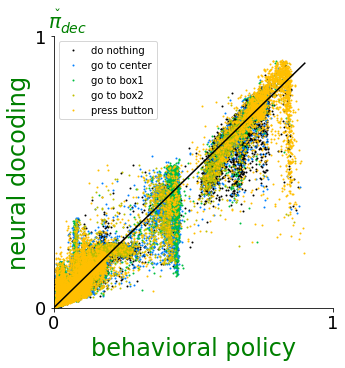

In [34]:
line_x = np.linspace(-.9,.9,num=11)
line_y = np.linspace(-.9,.9,num=11)


h = [[] for i in range(na)]
fig_decoding, ax = plt.subplots(1,1,figsize=(5,5))

for i in range(na):
    idx_act = np.where(y[:, 0] == i)[0]
    h[i] = ax.scatter(y[idx_act, 1:-1].reshape(-1, 1), 
                      predic_X_all[idx_act,:].reshape(-1, 1), color = act_cmap[i], s = 1)
    
ax.legend(h, ['do nothing',   'go to center',   'go to box1',   'go to box2',   'press button'])
ax.plot(line_x, line_y,c='k')
ax.set(xlim = [0, 1], ylim = [0, 1],xticks=[0, 1], yticks = [0, 1])
ax.set_xlabel('behavioral policy', fontsize = 24, color = 'green')
ax.set_ylabel('neural docoding', fontsize = 24, color = 'green')
ax.tick_params(labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.02, 1.03, '$\pi^{\check}_{dec}$',  fontsize = 20.0, color = 'green')

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(18)


